In [75]:
import numpy as np
import os
import math
from PIL import Image
import pandas as pd

# Clustering
from sklearn.cluster import AgglomerativeClustering # 1) Agglomerative-Hierarchical
from sklearn.cluster import KMeans                  # 2) K-Means
from sklearn.mixture import GaussianMixture         # 3) Gaussian Mixture Models

from skimage.color import rgb2hed
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn import metrics
from skimage.external import tifffile

from sklearn.decomposition import PCA               # 2) PCA
from sklearn.manifold import TSNE

# Load Autoencoder                                  # 3) Autoencoder (Deep dimensionality reduction)
from keras.models import load_model
from keras.models import Model

import cv2

import matplotlib.pyplot as plt 
%matplotlib inline

import newscripts as myutils

In [76]:
## Data loading

directory = "../../Data/Kather_all"

new_train = []
image_names = []

# Test on 1000 images
for filename in os.listdir(directory):
    if filename.endswith('.tif'):
        image = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_UNCHANGED)
        resized_image = cv2.resize(image, (96, 96)) 
        new_train.append(np.asarray( resized_image, dtype="uint8" ))
        image_names.append(filename)
        
labels_true = myutils.loadLabelsFromsubdirectoryindex(image_names, "../../Data/Kather_original")


In [77]:
meanMatrix = np.asarray(new_train)
meanMatrix = meanMatrix.astype('float32') / 255. # Normalize the values before predictions
print(meanMatrix.shape)

(5000, 96, 96, 3)


In [78]:
autoencoder = load_model('../../github/autoencoder_train_epochs100_batch32_best.h5') # 6 x 6 x 16
layer_name = 'conv2d_30' # 6 x 6 x 32
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)
X = encoder.predict(meanMatrix)
print(X.shape)

# autoencoder.summary()

(5000, 6, 6, 32)


In [80]:
X = X.reshape(X.shape[0] , -1) # Reshape for scaling
X = StandardScaler().fit_transform(X) # Scale

(5000, 1152)
HC Silhouette Score  0.15391398966312408 
kmeans Silhouette Score  0.16543200612068176 
gmm Silhouette Score  0.17203021049499512 


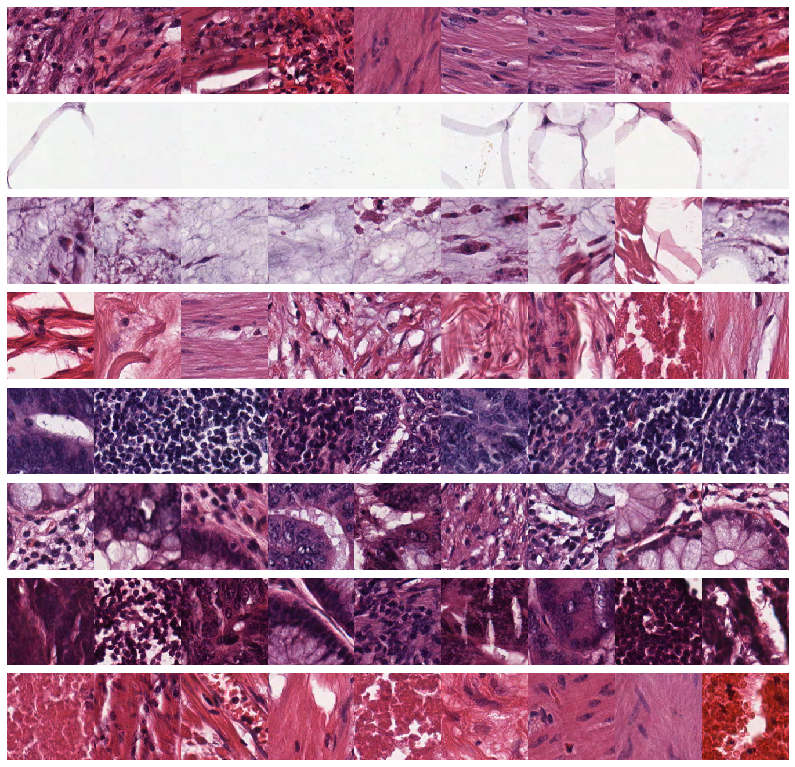

In [5]:


Labels = myutils.Cluster(8, X)
myutils.clusterintoDirectories(Labels[1], directory, image_names)
myutils.pltPathologyClusters(Labels[1], directory)

In [6]:
myutils.evaluateAll3withLabels(Labels, labels_true)

GMM Adjusted Rand index 0.5355464111216918
GMM homogeneity_score 0.5092276714669071
GMM adjusted_rand_score 0.4178646658229999
GMM completeness_score 0.5671620313840776
GMM v_measure_score 0.529510810255192


In [7]:
# PCA 
print(X.shape)
pca = PCA(n_components=0.85)
transformedData = pca.fit_transform(X)
transformedData.shape

(5000, 1152)


(5000, 206)

(5000, 206)
HC Silhouette Score  0.060025654733181 
kmeans Silhouette Score  0.137413889169693 
gmm Silhouette Score  0.1838594675064087 


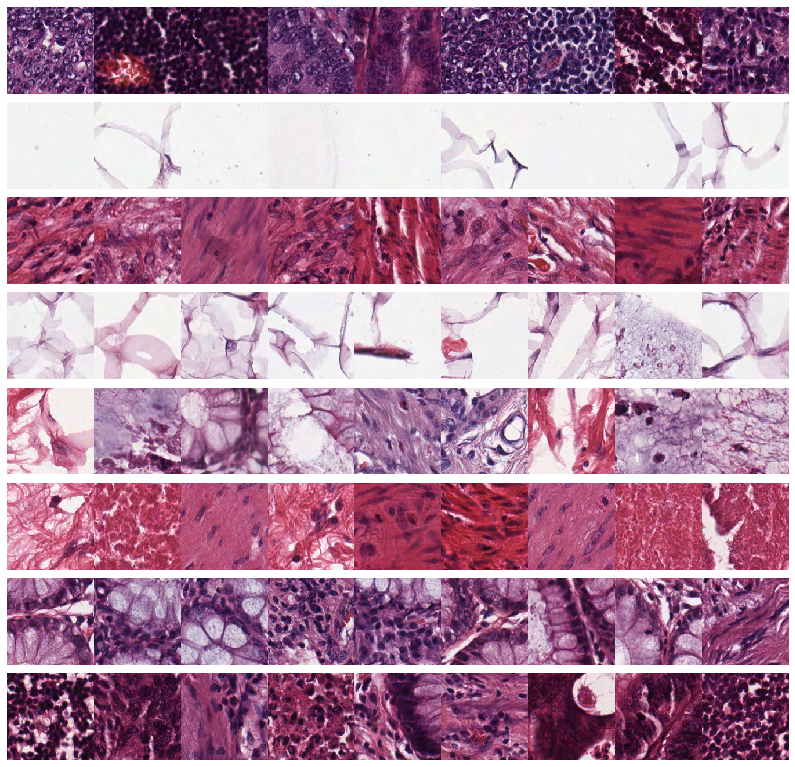

In [8]:
Labels = myutils.Cluster(8, transformedData)
myutils.clusterintoDirectories(Labels[1], directory, image_names)
myutils.pltPathologyClusters(Labels[1], directory)

In [9]:
myutils.evaluateAll3withLabels(Labels, labels_true)

KMeans Adjusted Rand index 0.5541298030481348
KMeans homogeneity_score 0.552442565796528
KMeans adjusted_rand_score 0.4096684475576703
KMeans completeness_score 0.5579622455634966
KMeans v_measure_score 0.5544996002882246


In [10]:
tsne1 = TSNE(n_components=2, perplexity = 40).fit_transform(transformedData)
kmeans1 = KMeans(n_clusters=8).fit(tsne1)

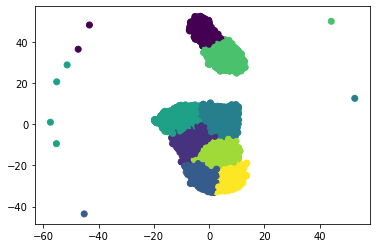

In [12]:
plt.scatter(tsne1[:,0], tsne1[:,1], c=kmeans1.labels_, cmap='viridis') 

In [13]:
transformedData.shape

(5000, 206)

In [25]:
kmeans1 = KMeans(n_clusters=8, random_state=1824).fit(transformedData)
kmeans2 = KMeans(n_clusters=8, random_state=19).fit(transformedData)
kmeans3 = KMeans(n_clusters=8, random_state=42).fit(transformedData)

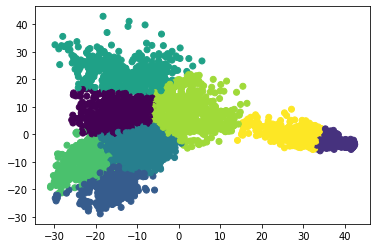

In [26]:
plt.scatter(transformedData[:,0], transformedData[:,1], c=kmeans1.labels_, cmap='viridis') 


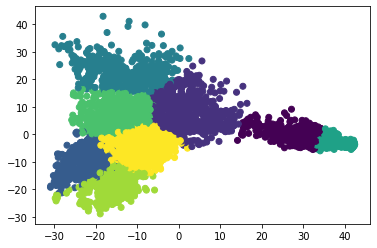

In [17]:
plt.scatter(transformedData[:,0], transformedData[:,1], c=kmeans2.labels_, cmap='viridis') 


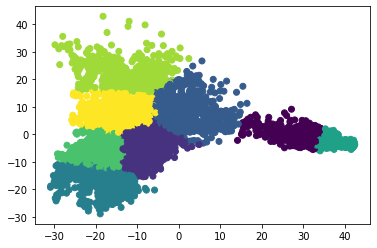

In [18]:
plt.scatter(transformedData[:,0], transformedData[:,1], c=kmeans3.labels_, cmap='viridis') 

In [27]:
print(metrics.completeness_score(kmeans1.labels_,labels_true))
print(metrics.completeness_score(kmeans2.labels_,labels_true))
print(metrics.completeness_score(kmeans3.labels_,labels_true))

0.5501192598033321
0.5484795630667085
0.5525902361763719


In [30]:
#PLEASE DO NOT CHANGE THIS CELL

#The various imports needed

#Standard python libraries for data analysis and visualisation
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#SciKit Learn a python ML Library
#Import models
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

#Load dataset
from sklearn import datasets

#Import data munging tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

#import useful metrics and linear algebra functions
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix
from scipy import linalg

%matplotlib inline

In [43]:
# PLEASE DO NOT CHANGE THIS CELL
def plot_data(X, y):
    plt.plot(X[y==0, 0], X[y==0, 1],"go", label="Setosa")
    plt.plot(X[y==1, 0], X[y==1, 1],"ro", label="Versicolor")
    plt.plot(X[y==2, 0], X[y==2, 1],"yo", label="Virginica")
#     plt.xlabel(iris_dt.feature_names[0],fontsize=10)
#     plt.ylabel(iris_dt.feature_names[1],fontsize=10)
    plt.legend()
    
def plot_predictions(y_true,y_pred):
    mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)
    
def plot_decision_boundaries(clusterer, X, y, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X,y)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel(iris_dt.feature_names[0], fontsize=12)
    else:
        plt.tick_params(labelbottom='off')
    if show_ylabels:
        plt.ylabel(iris_dt.feature_names[3], fontsize=12, rotation=90)
    else:
        plt.tick_params(labelleft='off')
        
def plot_kmeans_results(model, X, y, y_pred):
    #Plot matrix with predictions
    plt.subplot(131)
    plot_predictions(y,y_pred)

    #Plot true labels
    plt.subplot(132)
    plt.title("True labels")
    plot_data(X,y)

    #Plot predicted labels with the decision boundaries
    plt.subplot(133)
    plt.title("Predicted labels")
    plot_decision_boundaries(model, X,y_pred, show_xlabels=False,show_ylabels=False)

In [39]:
# PCA 
print(X.shape)
pca = PCA(n_components=2)
transformedData = pca.fit_transform(X)
transformedData.shape

(5000, 1152)


(5000, 2)

In [42]:
kmeans1 = KMeans(n_clusters=8, random_state=1824).fit(transformedData)


<Figure size 1224x288 with 0 Axes>

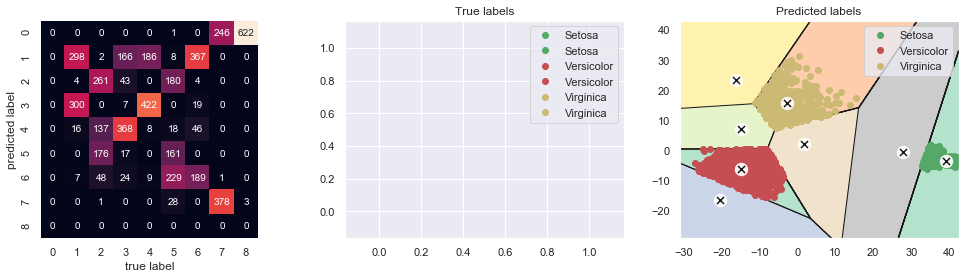

In [45]:
plt.figure(figsize=(17, 4))
plot_kmeans_results(kmeans1, transformedData, labels_true, kmeans1.labels_)

In [47]:
transformedData.shape

(5000, 2)

In [49]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(transformedData)
             for k in range(1, 6)]

#######################################################
# TO_DO
# [your code here]

bics = [gmm.bic(transformedData) for gmm in gms_per_k]
aics = [gmm.aic(transformedData) for gmm in gms_per_k]

# /TO_DO
##########################################################

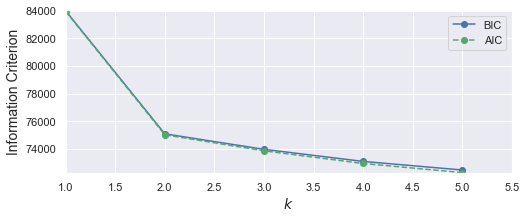

In [50]:
# PLEASE DO NOT CHANGE THIS CELL
plt.figure(figsize=(8, 3))
plt.plot(range(1, 6), bics, "bo-", label="BIC")
plt.plot(range(1, 6), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 5.5, np.min(aics) - 50, np.max(aics) + 70])
plt.legend()
plt.show()

In [52]:
# PLEASE DO NOT CHANGE THIS CELL

colors = ['green', 'red', 'yellow']

def plot_gaussians(X, Y_, means, covariances, covariance_type, index):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, colors)):
        
        if covariance_type == 'full':
            covar = covariances[i][:2, :2]
        elif covariance_type == 'tied':
            covar = covariances[:2, :2]
        elif covariance_type == 'diag':
            covar = np.diag(covariances[i][:2])
        elif covariance_type == 'spherical':
            covar = np.eye(means.shape[1]) * covariances[i]
            
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        
    plot_data(X,Y_)
    plt.xlim(4,8)
    plt.ylim(1.8,4.5)
    plt.title("Predicted labels")

In [58]:
bics

[84001.86660786177,
 75077.9598924197,
 73954.26422178137,
 73077.44549718409,
 72454.56187911348]

In [63]:
#######################################################
# TO_DO
# [your code here]

idx = bics.index(max(bics))
gm_best = GaussianMixture(n_components=8, n_init=10, covariance_type='full', random_state=42).fit(transformedData)

metrics.completeness_score(labels_true,gm_best.predict(transformedData))

0.5824819184203348

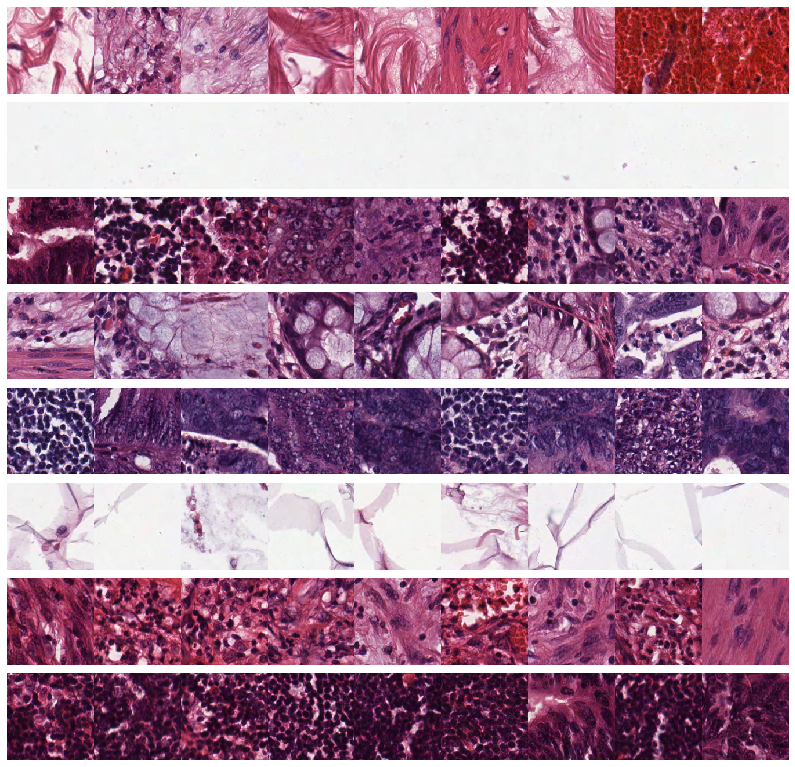

In [64]:
myutils.clusterintoDirectories(gm_best.predict(transformedData), directory, image_names)
myutils.pltPathologyClusters(gm_best.predict(transformedData), directory)

full Silhouette Score  0.39486977458000183 
tied Silhouette Score  0.34823599457740784 
diag Silhouette Score  0.3641107976436615 
spherical Silhouette Score  0.35741811990737915 


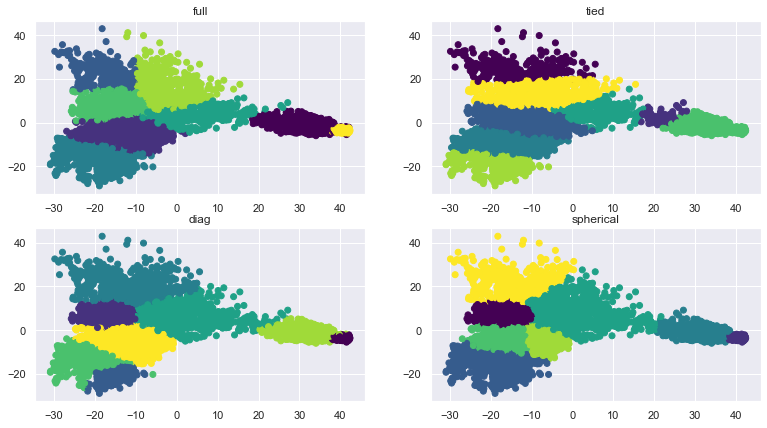

In [65]:
myutils.plotdiffGaussians(8,transformedData)

In [73]:
n_clusters=8
X = transformedData

gmm1 = GaussianMixture(n_components=n_clusters, n_init=10, random_state=42, covariance_type='full').fit(X)
gmmlabels1_ = gmm1.predict(X)

gmm2 = GaussianMixture(n_components=n_clusters, n_init=10, random_state=42, covariance_type='tied').fit(X)
gmmlabels2_ = gmm2.predict(X)

gmm3 = GaussianMixture(n_components=n_clusters, n_init=10, random_state=42, covariance_type='diag').fit(X)
gmmlabels3_ = gmm3.predict(X)

gmm4 = GaussianMixture(n_components=n_clusters, n_init=10, random_state=42, covariance_type='spherical').fit(X)
gmmlabels4_ = gmm4.predict(X)


In [74]:
print(metrics.completeness_score(labels_true, gmmlabels1_))
print(metrics.completeness_score(labels_true, gmmlabels2_))
print(metrics.completeness_score(labels_true, gmmlabels3_))
print(metrics.completeness_score(labels_true, gmmlabels4_))

0.5824819184203348
0.552546004663166
0.5545404108316673
0.5825489954673756


In [81]:
X.shape

(5000, 1152)

n_clusters: 8, 	 n_samples 5000, 	 n_features 1152
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	4.68s	2726882	0.548	0.557	0.553	0.405	0.551	0.118
random   	4.00s	2728527	0.553	0.559	0.556	0.409	0.555	0.116
PCA-based	0.48s	2738495	0.516	0.534	0.525	0.383	0.523	0.174
__________________________________________________________________________________


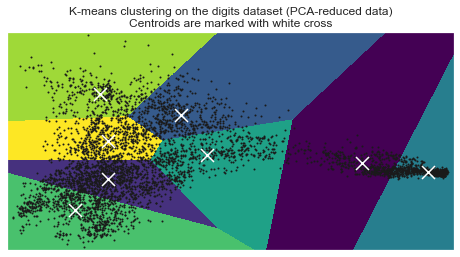

In [106]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)
data = X
n_digits = 8
labels = labels_true
sample_size = 5000
n_features = 1152

print("n_clusters: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, sample_size, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 4))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#            cmap=plt.cm.Paired,
           cmap='viridis',
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [97]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer

In [92]:
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state=42)
splits = skf.split(transformedData, labels_true)

In [93]:
kmeans1 = KMeans(n_clusters=8, random_state=1824).fit(transformedData)

In [98]:
scores = cross_val_score(kmeans1, transformedData, labels_true, cv=splits, scoring=make_scorer(metrics.completeness_score))

In [99]:
scores

array([0.55504307, 0.55255503, 0.56892214, 0.57993392, 0.58050744,
       0.56539079, 0.58419368, 0.55092475, 0.57715715, 0.56363217])

In [100]:
sum(scores)/len(scores)

0.5678260149571598

In [107]:
# PLEASE DO NOT CHANGE THIS CELL

colors = ['green', 'red', 'yellow']

def plot_gaussians(X, Y_, means, covariances, covariance_type, index):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, colors)):
        
        if covariance_type == 'full':
            covar = covariances[i][:2, :2]
        elif covariance_type == 'tied':
            covar = covariances[:2, :2]
        elif covariance_type == 'diag':
            covar = np.diag(covariances[i][:2])
        elif covariance_type == 'spherical':
            covar = np.eye(means.shape[1]) * covariances[i]
            
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        
    plot_data(X,Y_)
    plt.xlim(4,8)
    plt.ylim(1.8,4.5)
    plt.title("Predicted labels")

In [109]:
gmm1 = GaussianMixture(n_components=n_clusters, n_init=10, random_state=42, covariance_type='full').fit(transformedData)
gmmlabels1_ = gmm1.predict(transformedData)


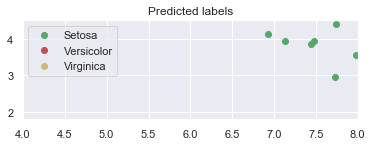

In [111]:
plot_gaussians(transformedData, gmmlabels1_, gmm1.means_, gmm1.covariances_, gmm1.covariance_type, 0)

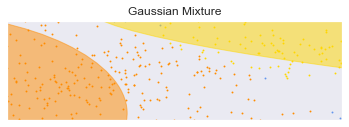

In [118]:
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


# Number of samples per component
n_samples = 5000

# Generate random sample, two components
np.random.seed(0)
# C = np.array([[0., -0.1], [1.7, .4]])
X = transformedData

# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

# Fit a Dirichlet process Gaussian mixture using five components
# dpgmm = mixture.BayesianGaussianMixture(n_components=5,
#                                         covariance_type='full').fit(X)
# plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
#              'Bayesian Gaussian Mixture with a Dirichlet process prior')

plt.show()

In [113]:
dpgmm = mixture.BayesianGaussianMixture(n_components=8,
                                        covariance_type='full').fit(transformedData)
y_pred = dpgmm.predict(transformedData)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [114]:
metrics.completeness_score(labels_true,y_pred)

0.548779505883096

In [127]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

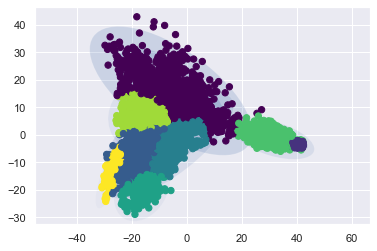

In [128]:
plot_gmm(gmm1, transformedData)

In [132]:
transformedData.shape

(5000, 2)

(5000, 2)
(5000, 2)
(5000, 2)


No handles with labels found to put in legend.


(5000, 2)


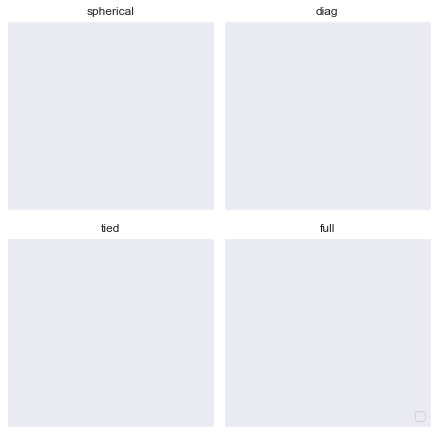

In [137]:
# Author: Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

# print(__doc__)

colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

# iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(transformedData, labels_true)))

X_train = transformedData
# X_train = iris.data[train_index]
# y_train = iris.target[train_index]
# X_test = iris.data[test_index]
# y_test = iris.target[test_index]

n_classes = len(np.unique(labels_true))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
#     estimator.means_init = np.array([X_train[labels_true == i].mean(axis=0)
#                                     for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    print(X_train.shape)
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

#     for n, color in enumerate(colors):
#         data = iris.data[iris.target == n]
#         plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
#                     label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_train[labels_true == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

#     y_train_pred = estimator.predict(X_train)
#     train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
#     plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
#              transform=h.transAxes)

#     y_test_pred = estimator.predict(X_test)
#     test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
#     plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
#              transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()